In [43]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager

sc = MinMaxScaler()

# 데이터 불러오기
# CSV를 데이터 프레임으로 변경
with open("data/k-league-data-20240624-1042-merged.csv", mode='r') as file:
    data = pd.read_csv(file)
    df = pd.DataFrame(data)

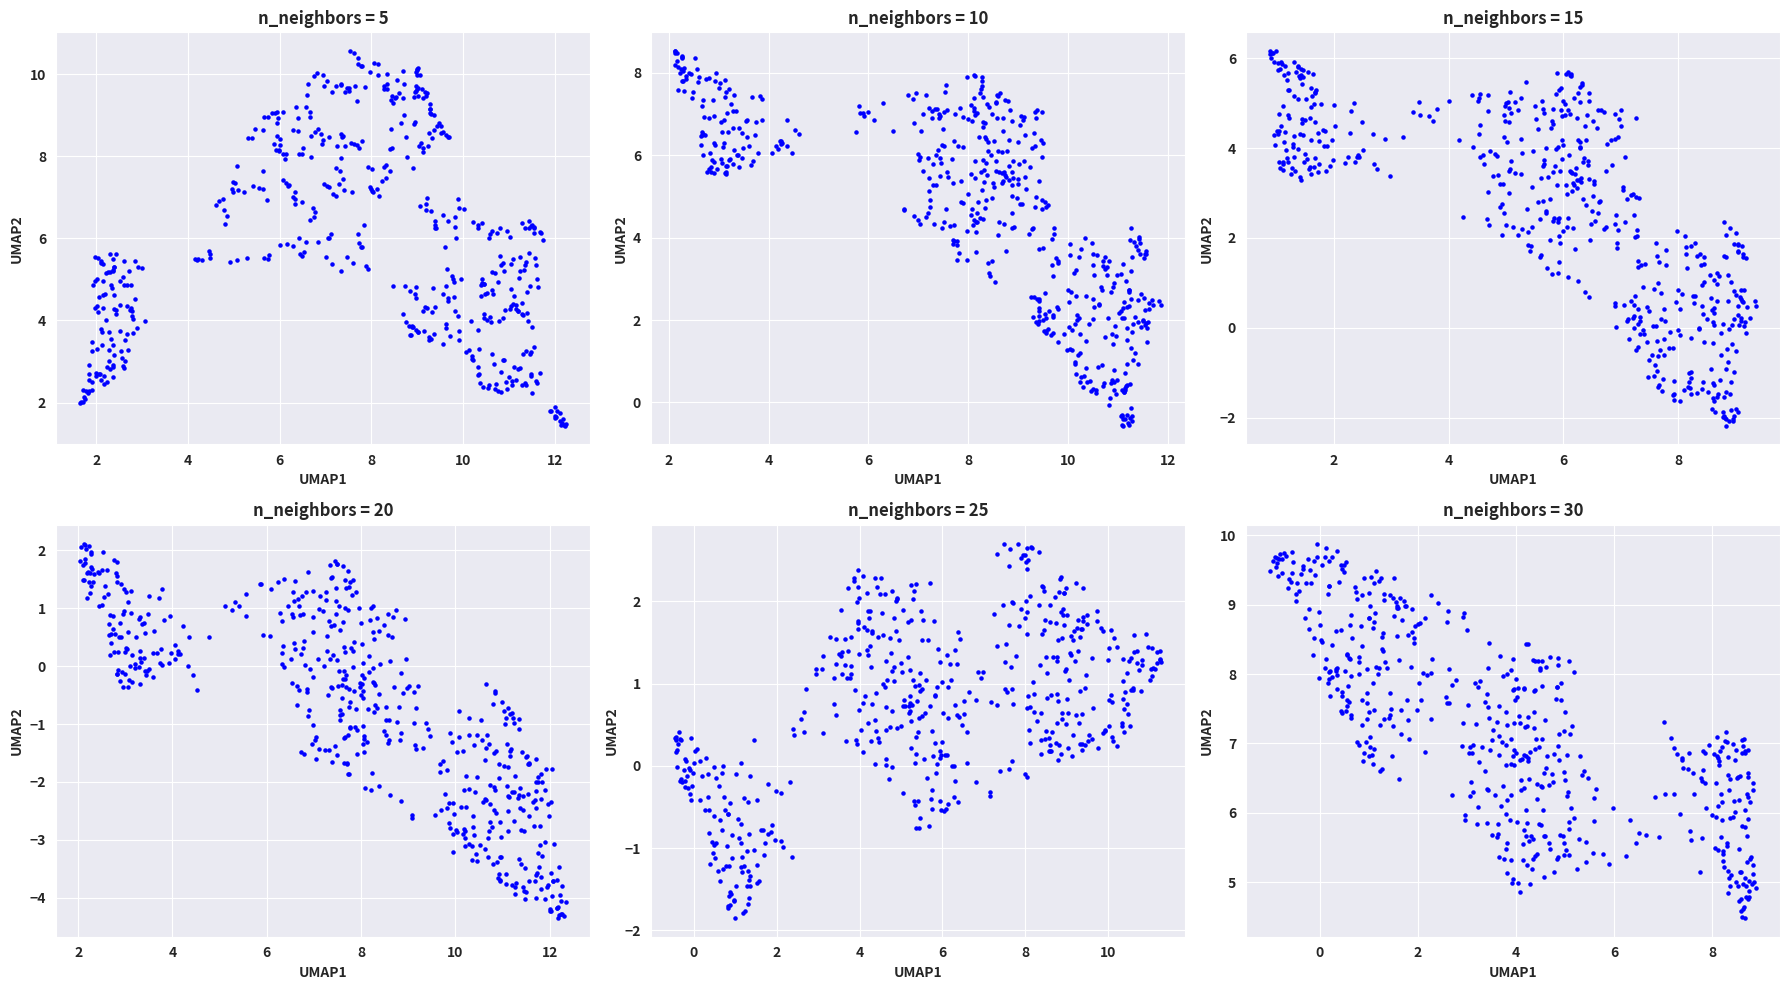

In [44]:
def calculate_pass_direction(row):
    forward_passes = row['전방 패스 성공']
    backward_passes = row['후방 패스 성공']
    sideways_passes = row['횡패스 성공']
    
    # 가중치를 주고 벡터 합산
    resultant_vector = (forward_passes * forward_vector + 
                        backward_passes * backward_vector + 
                        sideways_passes * sideways_vector)
    
    # 벡터 정규화
    magnitude = np.linalg.norm(resultant_vector)
    if magnitude > 0:
        normalized_vector = resultant_vector / magnitude
    else:
        normalized_vector = resultant_vector
    
    return pd.Series(normalized_vector)


# 양호한 분류를 위해 뚜렷하게 구분되는 GK 포지션과 출전시간이 부족한 선수를 분석 대상에서 제외
df = df[df["포지션"] != "GK"]
df = df[df["출전시간(분)"] > 100]
df = df[df['포지션'] != '대기']

#Feature engineering - Defensive Action
# 경기당 데이터로 변환할 컬럼
columns_to_normalize = [
    '득점', '도움', '슈팅', '유효 슈팅', '차단된슈팅', '벗어난슈팅', 'PA내 슈팅', 'PA외 슈팅',
    '오프사이드', '프리킥', '코너킥', '스로인', '드리블 시도', '드리블 성공', '패스 시도', '패스 성공',
    '키패스', '전방 패스 시도', '전방 패스 성공', '후방 패스 시도', '후방 패스 성공', '횡패스 시도',
    '횡패스 성공', '공격지역패스 시도', '공격지역패스 성공', '수비지역패스 시도', '수비지역패스 성공',
    '중앙지역패스 시도', '중앙지역패스 성공', '롱패스 시도', '롱패스 성공', '중거리패스 시도',
    '중거리패스 성공', '숏패스 시도', '숏패스 성공', '크로스 시도', '크로스 성공', '경합 지상 시도',
    '경합 지상 성공', '경합 공중 시도', '경합 공중 성공', '태클 시도', '태클 성공', '클리어링',
    '인터셉트', '차단', '획득', '블락', '볼미스', '파울', '피파울', '경고', '퇴장'
]

# 대상 컬럼의 데이터를 (출전시간 / 90)으로 나누어 경기 당 이벤트 데이터로 변환
# 데이터 표준화 실행
for col in columns_to_normalize:
    num_matches = df['출전시간(분)'] / 90
    df[col] = df[col] / num_matches
    df[col] = sc.fit_transform(df[[col]])

# 차원 축소를 위한 컬럼 설정
columns = [
    "선수명",
    "슈팅", "유효 슈팅", "PA내 슈팅", "PA외 슈팅",
    "오프사이드",
    "드리블 성공", "키패스", "Pass Direction X", "Pass Direction Y", "크로스 성공"
    ,"경합 공중 성공", "태클 성공",
    "클리어링", "인터셉트", "차단", "획득", "블락", "볼미스", "파울", "피파울"
]

# 기본 벡터 설정
forward_vector = np.array([0, 1])
backward_vector = np.array([0, -1])
sideways_vector = np.array([1, 0])

direction_vectors = df.apply(calculate_pass_direction, axis=1)
df[['Pass Direction X', 'Pass Direction Y']] = direction_vectors

data_selecting = df[columns]
data_selected = data_selecting.iloc[:, 1:] # 문자열인 선수명을 제외
data_selected = data_selected.fillna(0) # 결측치 처리

# 하이퍼 파라미터 엔지니어링
num_samples = data_selected.shape[0]
n_neighbors_min = max(2, int(num_samples * 0.01))  # 데이터 포인트의 1%를 최소값으로 설정

n_neighbors_values = range(n_neighbors_min, 151, 5)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, n_neighbors in zip(axes.flatten(), n_neighbors_values):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, n_components=2)
    embedding = reducer.fit_transform(data_selected)
    
    ax.scatter(embedding[:, 0], embedding[:, 1], s=5, c='blue')
    ax.set_title(f'n_neighbors = {n_neighbors}')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
plt.tight_layout()
plt.show()

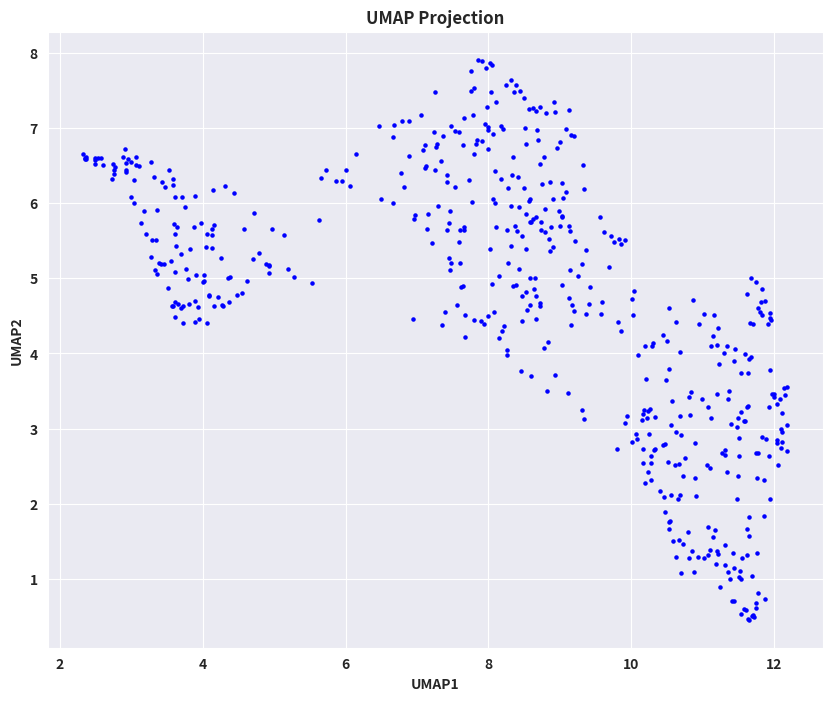

In [47]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(data_selected)
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])

# 차원 축소 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c='blue')
plt.title('UMAP Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

In [48]:
from sklearn.mixture import GaussianMixture

# GMM 모델 설정 및 피팅
gmm = GaussianMixture(n_components=5, random_state=82)
gmm.fit(embedding)

# 클러스터 레이블 예측
cluster_labels = gmm.predict(embedding)

# 결과를 데이터 프레임에 추가
embedding_df['Cluster'] = cluster_labels
df = df.copy()
df.loc[:, 'Cluster'] = cluster_labels
data_selected = data_selected.copy()
data_selected.loc[:, 'Cluster'] = cluster_labels

In [49]:
features = ["슈팅", "유효 슈팅", "PA내 슈팅", "PA외 슈팅",
    "오프사이드",
    "드리블 시도", "키패스", "전방 패스 시도", "후방 패스 시도",
    "횡패스 시도",
    "공격지역패스 시도", "수비지역패스 시도",
    "중앙지역패스 시도", "롱패스 시도", "중거리패스 시도",
    "숏패스 시도", "크로스 시도", "경합 공중 시도",
    "태클 시도",
    "클리어링", "인터셉트", "차단", "획득", "블락", "볼미스", "파울", "피파울"
]

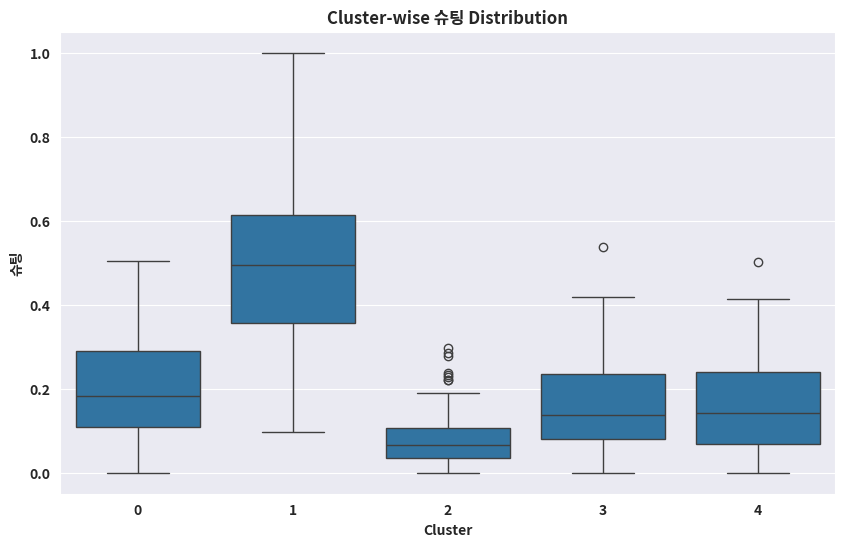

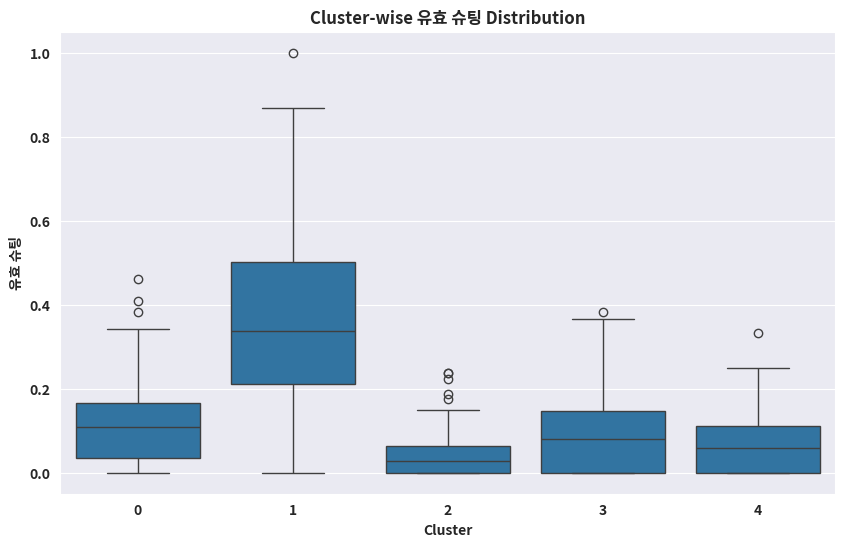

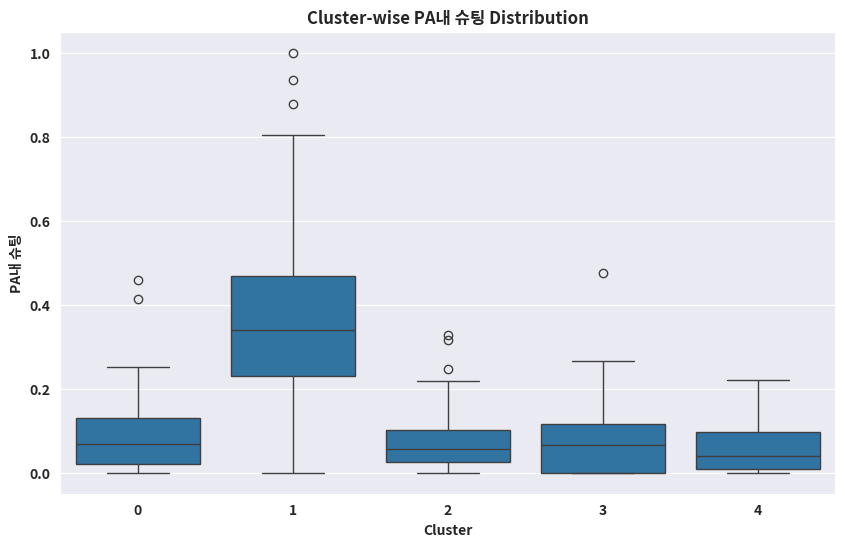

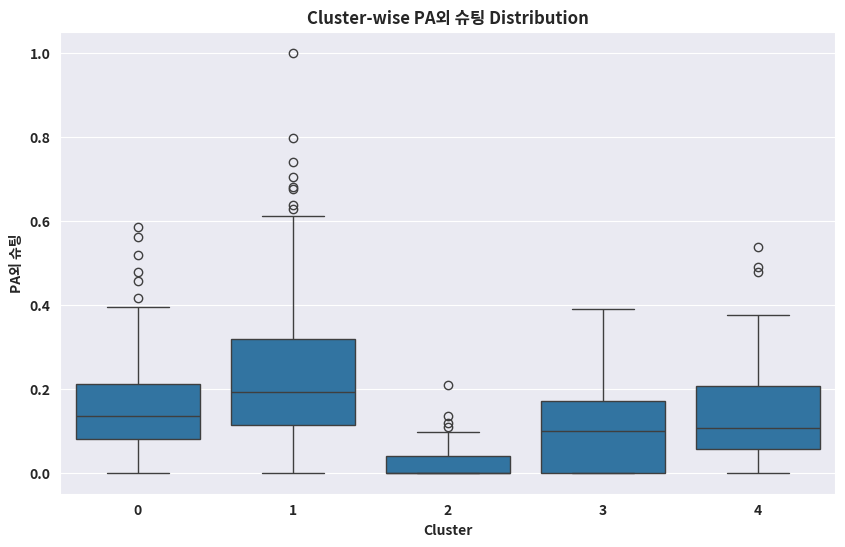

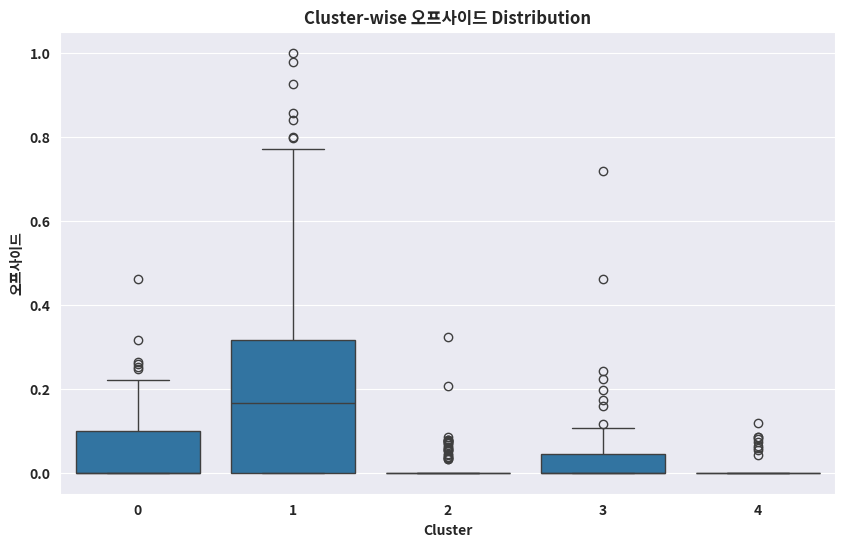

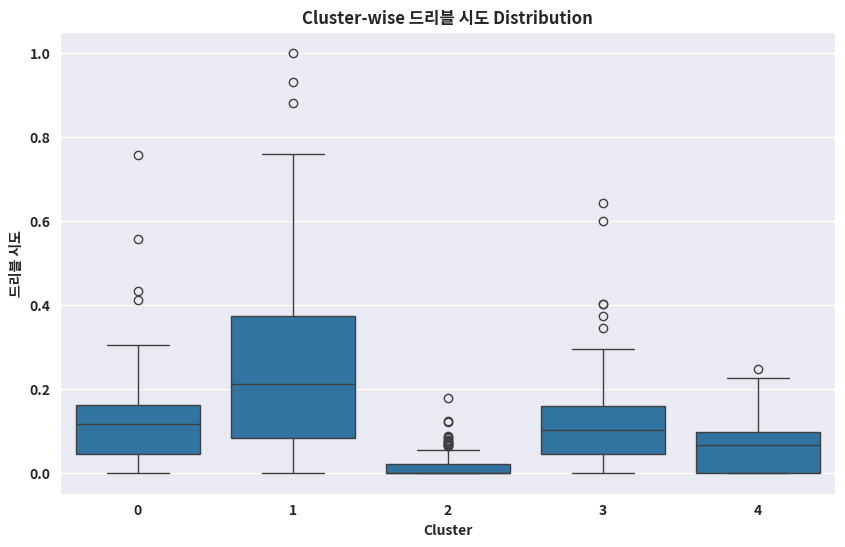

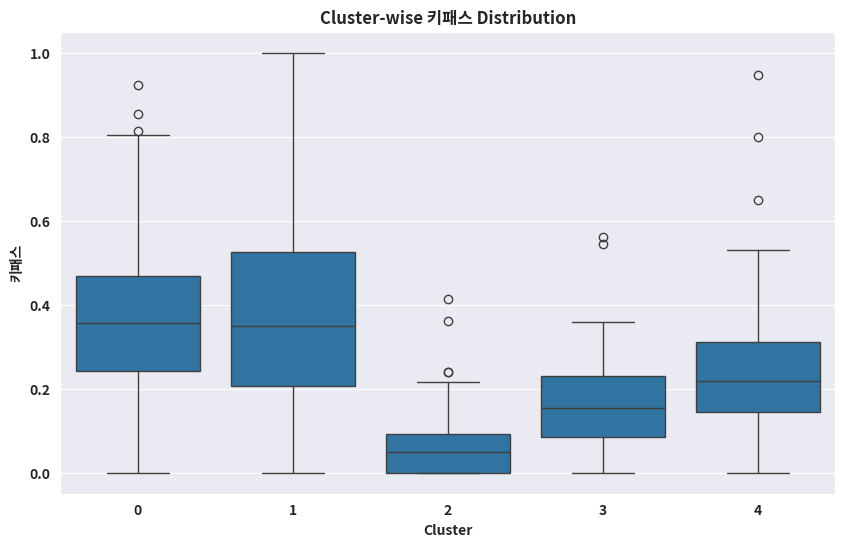

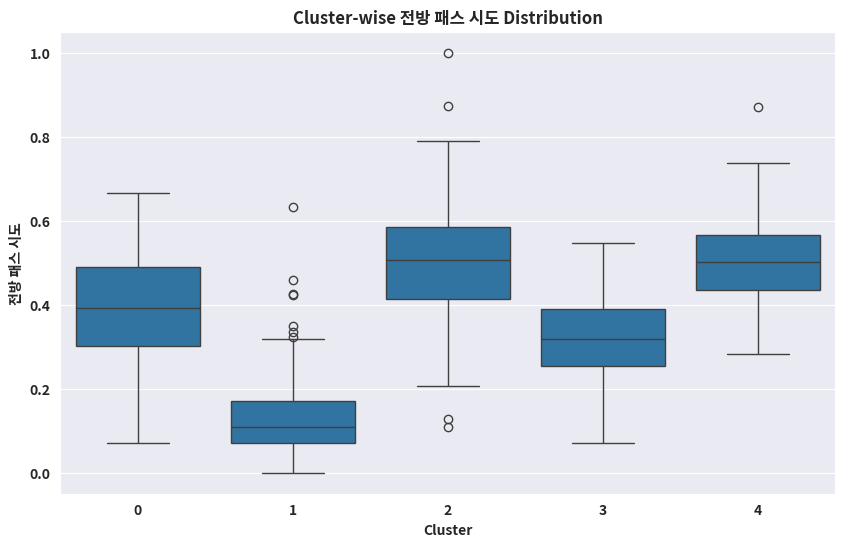

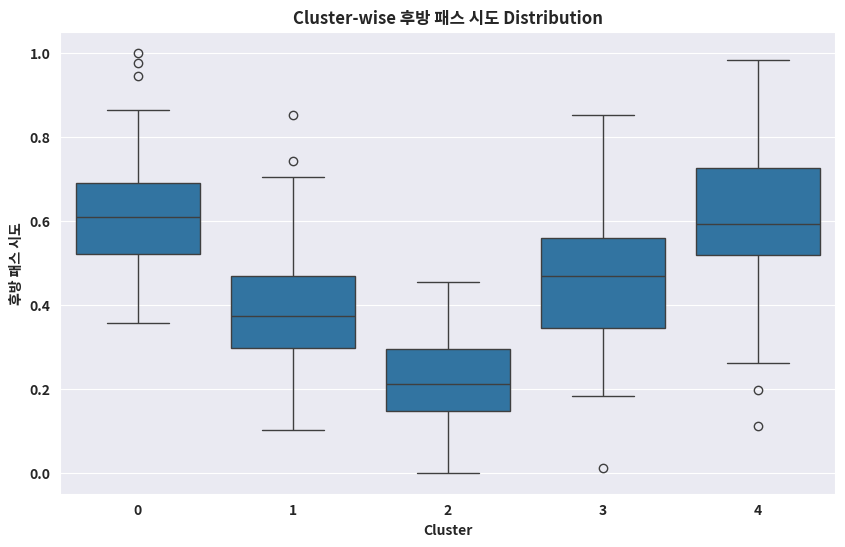

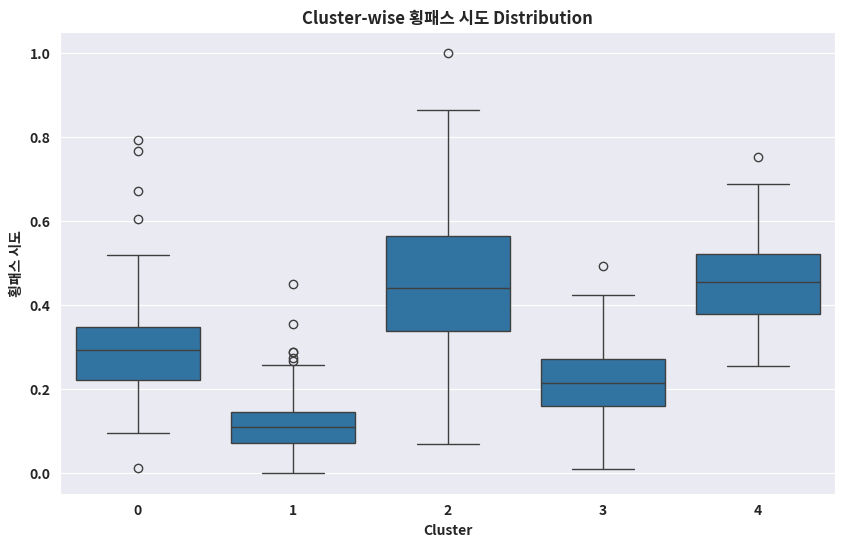

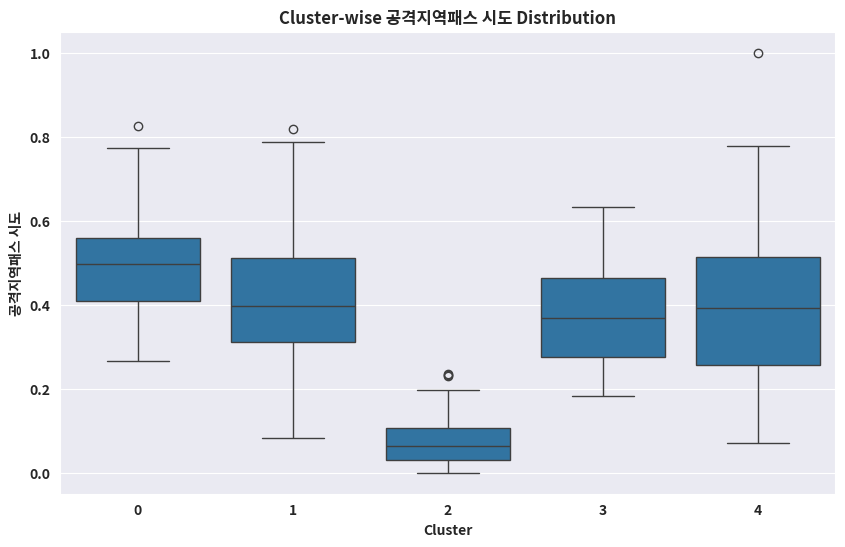

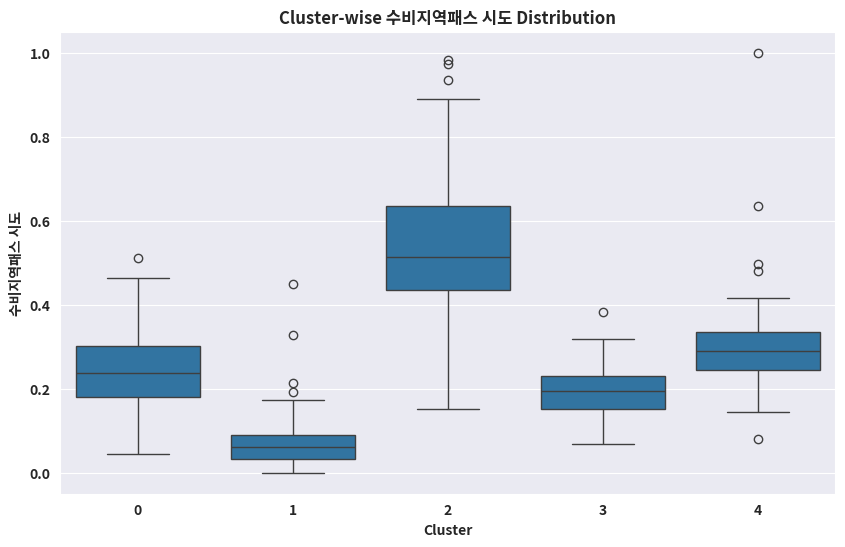

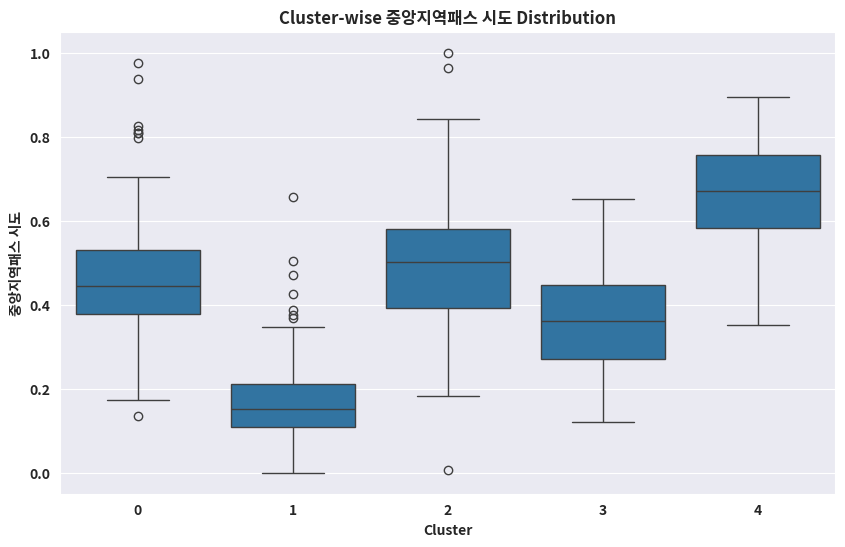

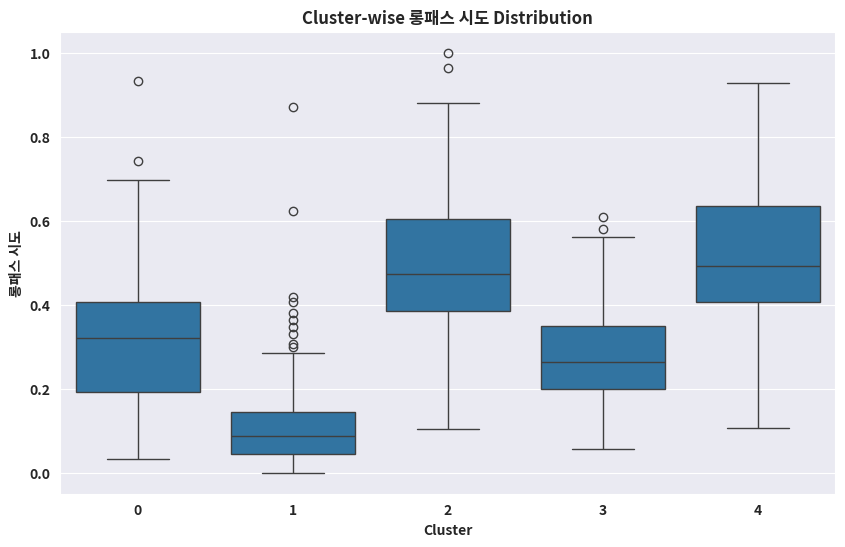

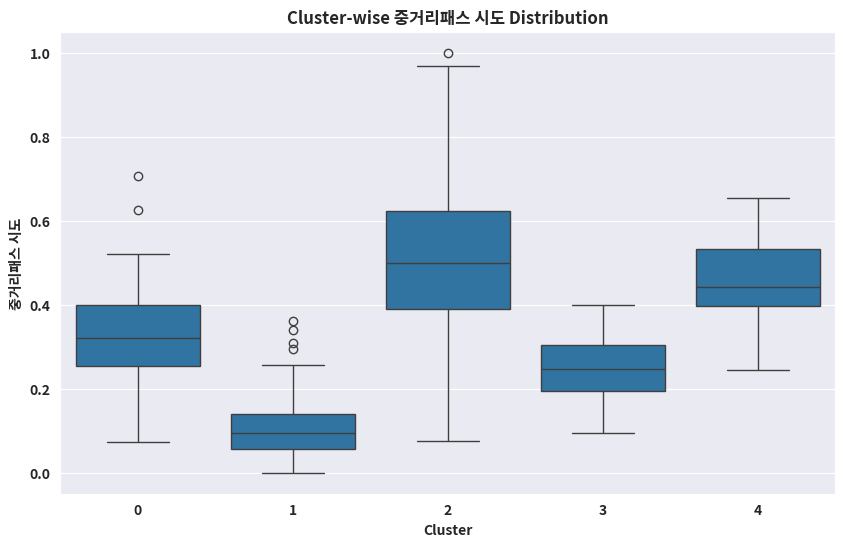

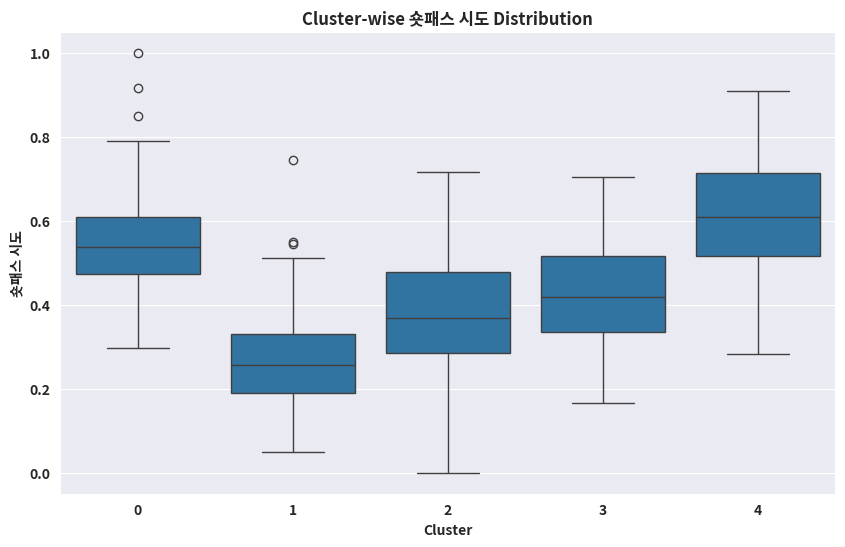

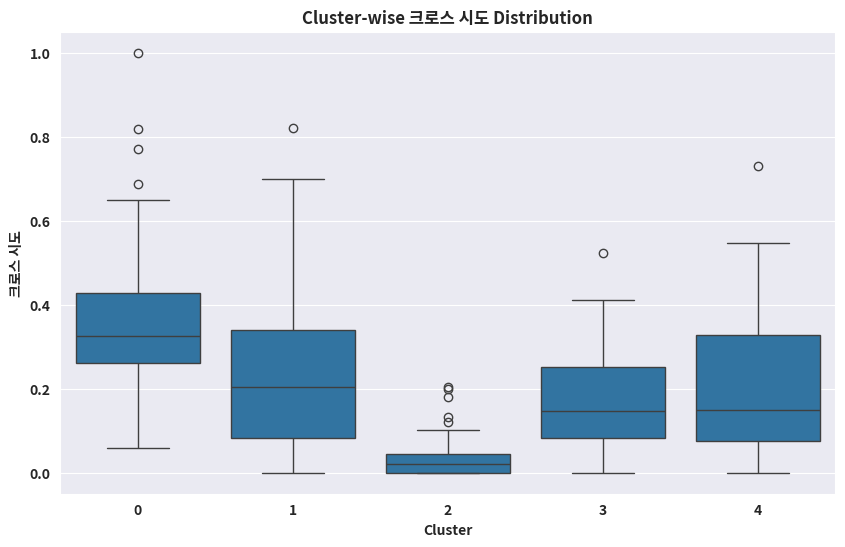

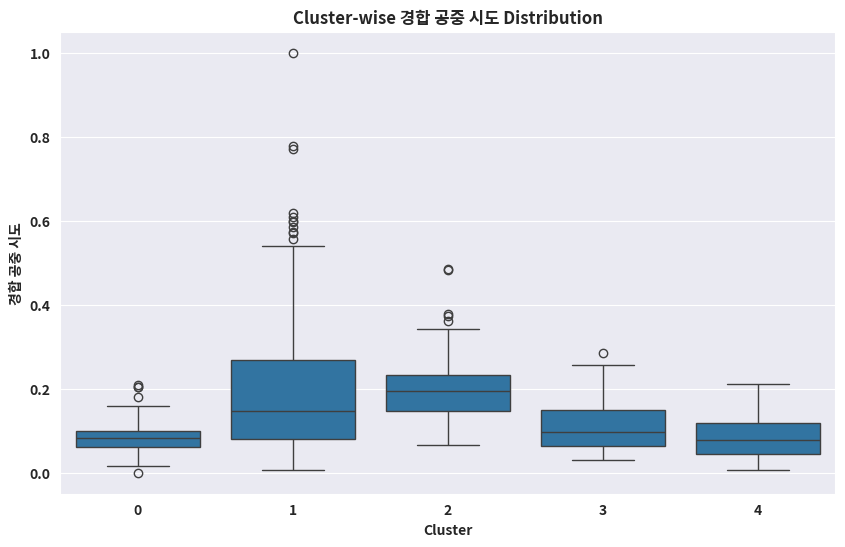

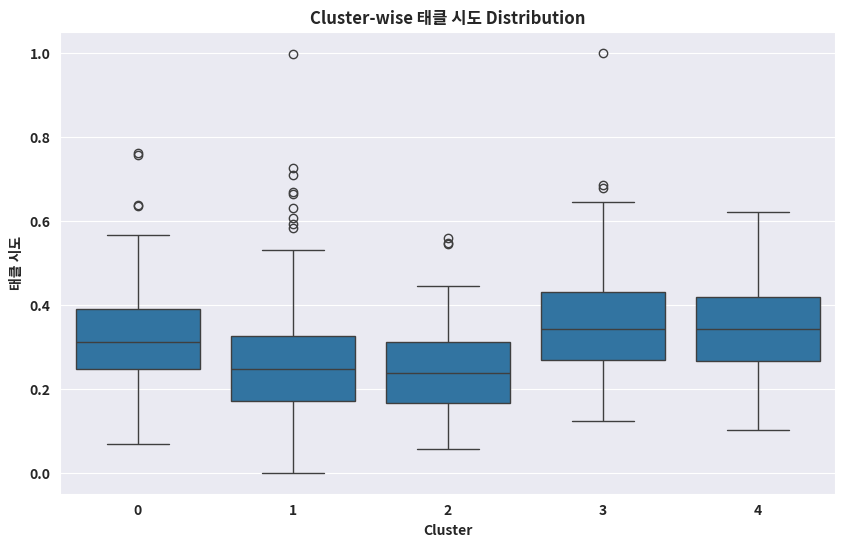

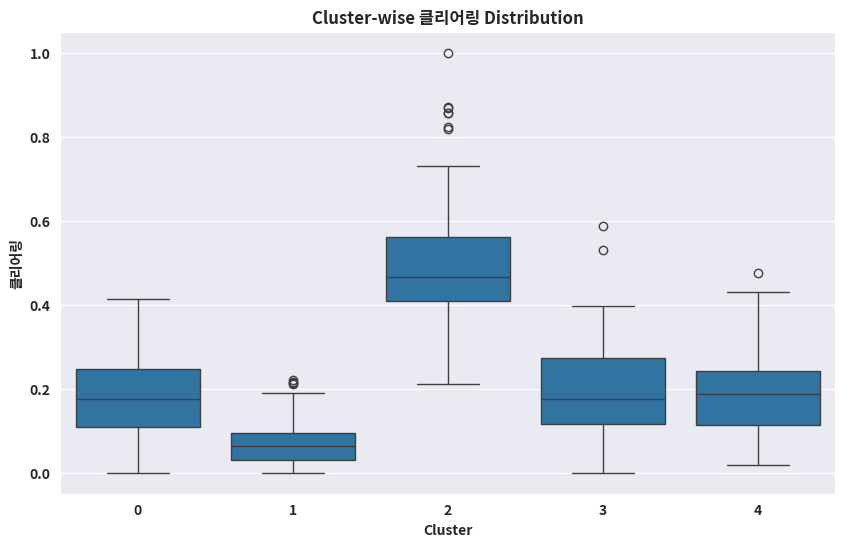

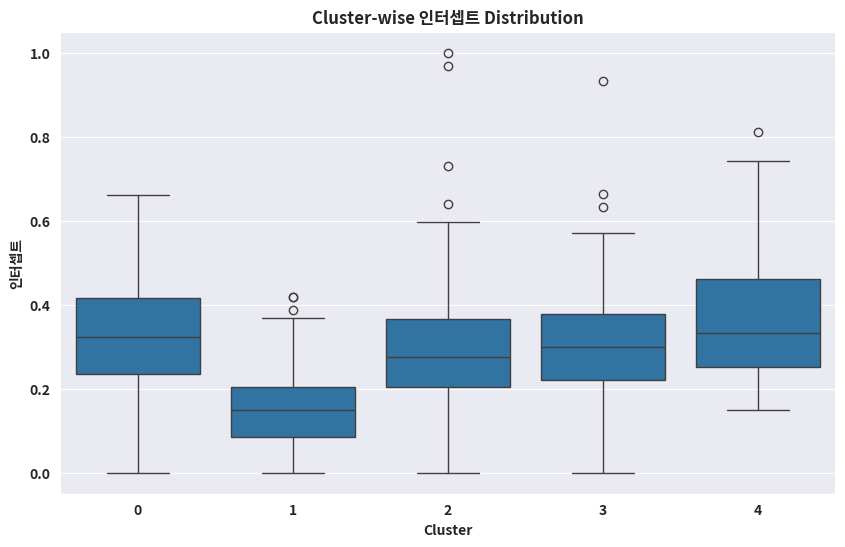

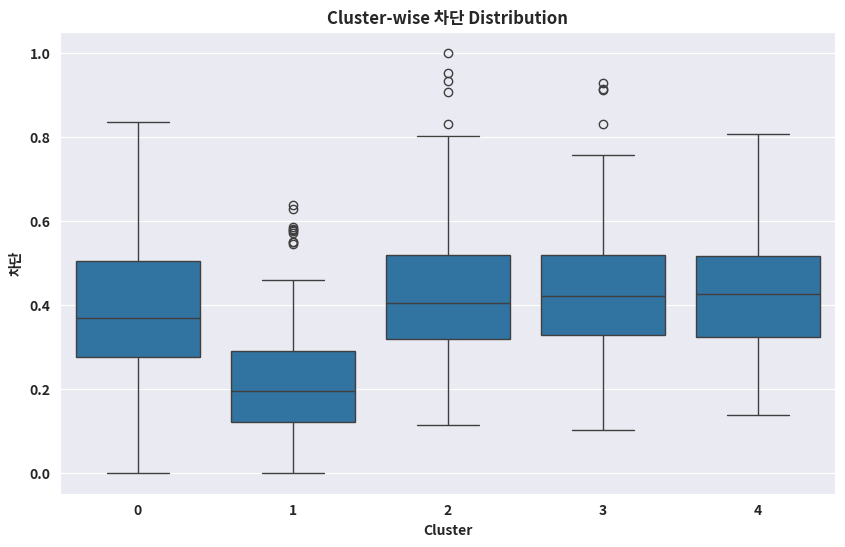

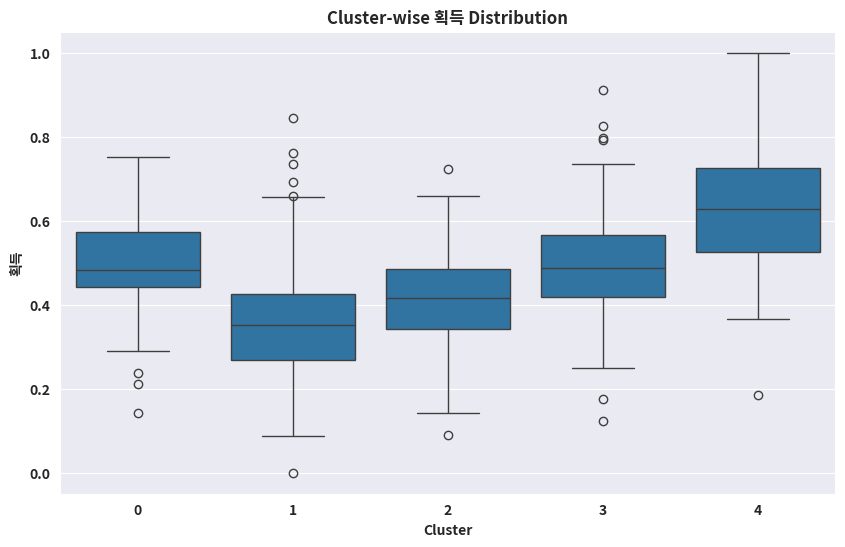

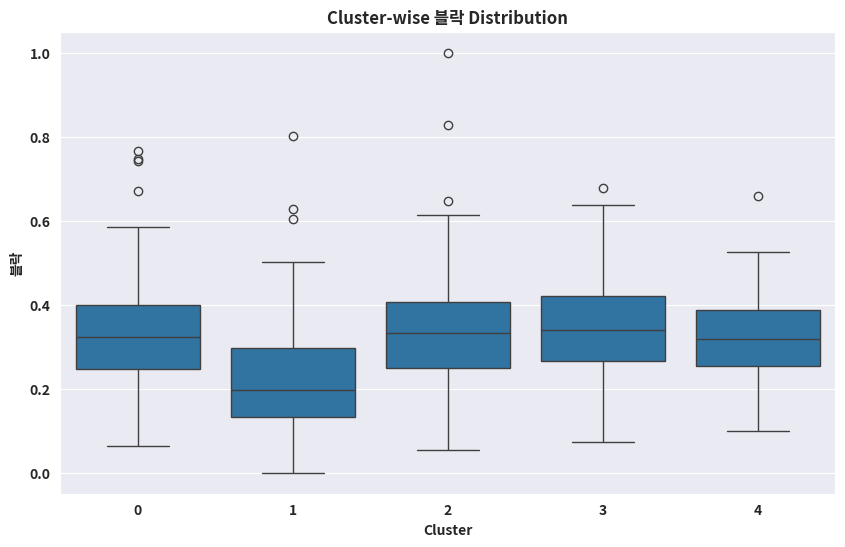

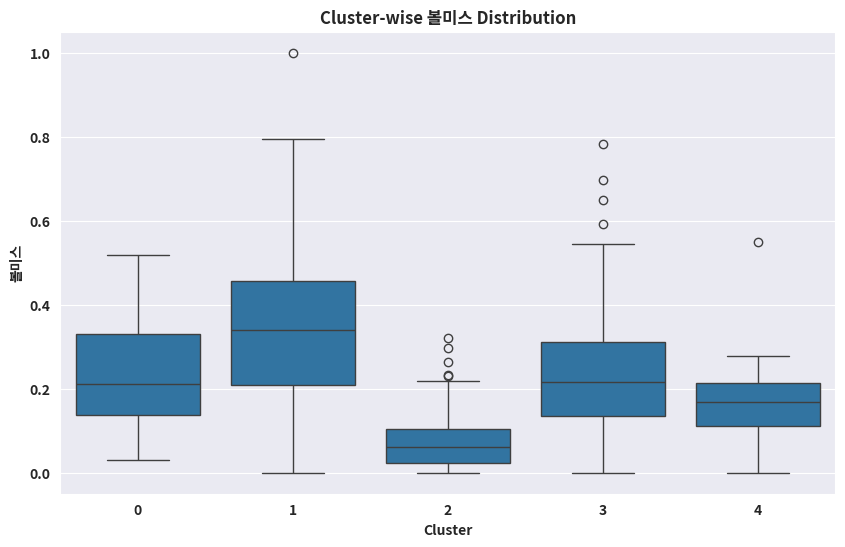

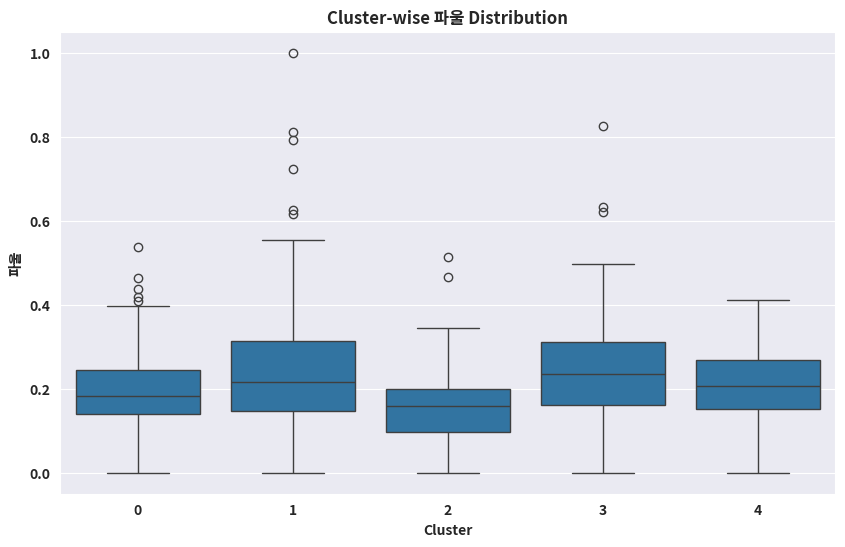

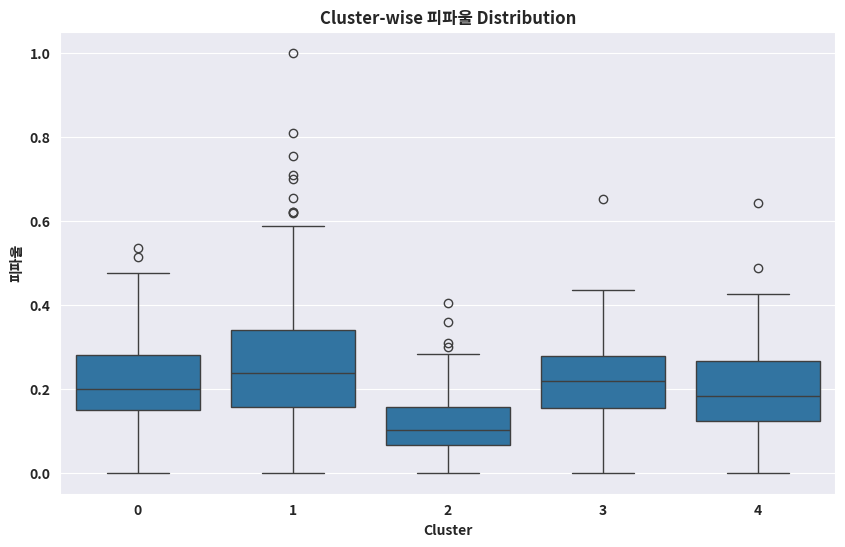

In [50]:
# Noto Sans CJK 폰트 파일 경로를 설정합니다
font_path = "Noto_Sans_KR/static/NotoSansKR-Bold.ttf"

font_manager.fontManager.addfont(font_path)
font_prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 박스 플롯
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=df)
    plt.title(f'Cluster-wise {feature} Distribution')
    plt.show()


In [51]:
# 통계적 유의성 검정
import scipy.stats as stats


def anova(frame, feat):
    for f in feat:
        # ANOVA 검정
        anova_result = stats.f_oneway(
            # frame[frame['Cluster'] == 0][f],
            # frame[frame['Cluster'] == 1][f],
            frame[frame['Cluster'] == 2][f],
            # frame[frame['Cluster'] == 3][f],
            frame[frame['Cluster'] == 4][f],
        )
        
        print(f"ANOVA F-value: {anova_result.statistic}, p-value: {anova_result.pvalue}")
        
        # p-value가 0.005보다 작으면 군집 간 차이가 유의미함을 나타냄
        if anova_result.pvalue < 0.005:
            print(f"군집 간 {f}의 차이가 통계적으로 유의합니다.")
        else:
            print(f"군집 간 {f}의 차이가 통계적으로 유의하지 않습니다.")
            
anova(df, features)


ANOVA F-value: 37.28821480230381, p-value: 6.650402550772305e-09
군집 간 슈팅의 차이가 통계적으로 유의합니다.
ANOVA F-value: 10.353064970970898, p-value: 0.0015463490656133466
군집 간 유효 슈팅의 차이가 통계적으로 유의합니다.
ANOVA F-value: 1.1158223416958333, p-value: 0.2923098591831706
군집 간 PA내 슈팅의 차이가 통계적으로 유의하지 않습니다.
ANOVA F-value: 92.5975235838039, p-value: 8.67246180565494e-18
군집 간 PA외 슈팅의 차이가 통계적으로 유의합니다.
ANOVA F-value: 0.40991551850643543, p-value: 0.5228693440918717
군집 간 오프사이드의 차이가 통계적으로 유의하지 않습니다.
ANOVA F-value: 52.36652747022557, p-value: 1.486151348239628e-11
군집 간 드리블 시도의 차이가 통계적으로 유의합니다.
ANOVA F-value: 109.78411998174158, p-value: 3.7171643669588866e-20
군집 간 키패스의 차이가 통계적으로 유의합니다.
ANOVA F-value: 0.009644163560895171, p-value: 0.9218847672784076
군집 간 전방 패스 시도의 차이가 통계적으로 유의하지 않습니다.
ANOVA F-value: 298.09056736838346, p-value: 2.573667287046328e-39
군집 간 후방 패스 시도의 차이가 통계적으로 유의합니다.
ANOVA F-value: 0.08554089909984766, p-value: 0.7702789903222607
군집 간 횡패스 시도의 차이가 통계적으로 유의하지 않습니다.
ANOVA F-value: 309.69733501114234, p-valu

In [52]:
positions = ["DEFENDER", "ADVANCED MIDFIELDER", "CENTRAL MIDFIELDER", "DEEP MIDFIELDER", "ATTACKER"]

# 군집 분석의 예측값을 최초 데이터 프레임에 저장
df['Position'] = df['Cluster'].apply(lambda x: positions[x])

# 세부 포지션 분석 후 예측값을 데이터 프레임에 저장하기 위한 임시값 설정
df['Second Position'] = "Null"

print(df.head())

    선수명 포지션  등번호  출전시간(분)        득점        도움        슈팅     유효 슈팅     차단된슈팅  \
0  가브리엘  FW   10     2004  0.168330  0.145709  0.427055  0.315619  0.248836   
1   갈레고  MF   11      136  0.000000  0.000000  0.873997  0.310049  1.000000   
2   강민규  MF    9     1341  0.314442  0.108874  0.762287  0.377330  0.236639   
4   강민승  MF   16      117  0.000000  0.000000  0.406371  0.720798  0.000000   
6   강상우  DF   15     1274  0.000000  0.057300  0.223919  0.132391  0.000000   

      벗어난슈팅  ...        파울       피파울        경고   퇴장    구단  Pass Direction X  \
0  0.195858  ...  0.220933  0.459309  0.092814  0.0    강원          0.443877   
1  0.288603  ...  0.283088  0.000000  0.455882  0.0    강원          0.077666   
2  0.702461  ...  0.200969  0.061013  0.138702  0.0  충남아산          0.216462   
4  0.000000  ...  0.329060  0.174825  0.000000  0.0  충북청주          0.210129   
6  0.246468  ...  0.060440  0.433495  0.097331  0.0    서울          0.540046   

   Pass Direction Y  Cluster             Position 

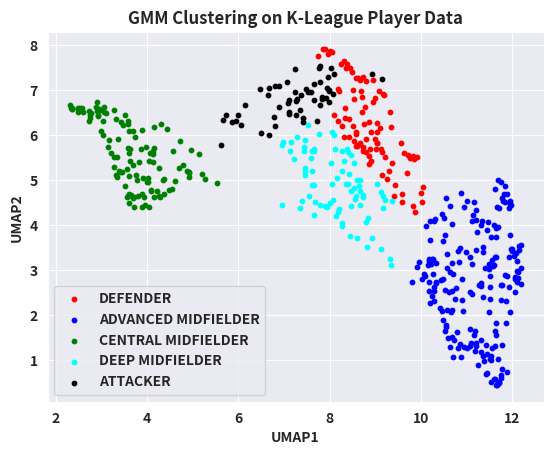

In [53]:
colors = ['red', 'blue', 'green', 'cyan', 'black', 'magenta', 'orange']

# 예측 결과가 적용된 산포도
for i in range(5):
    cluster_data = embedding_df[embedding_df['Cluster'] == i]
    plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
                color=colors[i], label=positions[i], s=10)

plt.title('GMM Clustering on K-League Player Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()

# DEFENDER

통계적으로 유의미한 높은 수비 데이터 수치

---

# ATTACKER

높은 박스 내 슈팅과 공중볼 경합 시도 수치

---

# CENTRAL MIDFIELDER

전반적으로 평균적인 수치 및 높은 패스 수치

---

# ADVANCED MIDFIELDER

높은 공격 데이터 수치

---

# DEEP MIDFIELDER

압도적으로 높은 패스 수치 및 소유권 회복

---



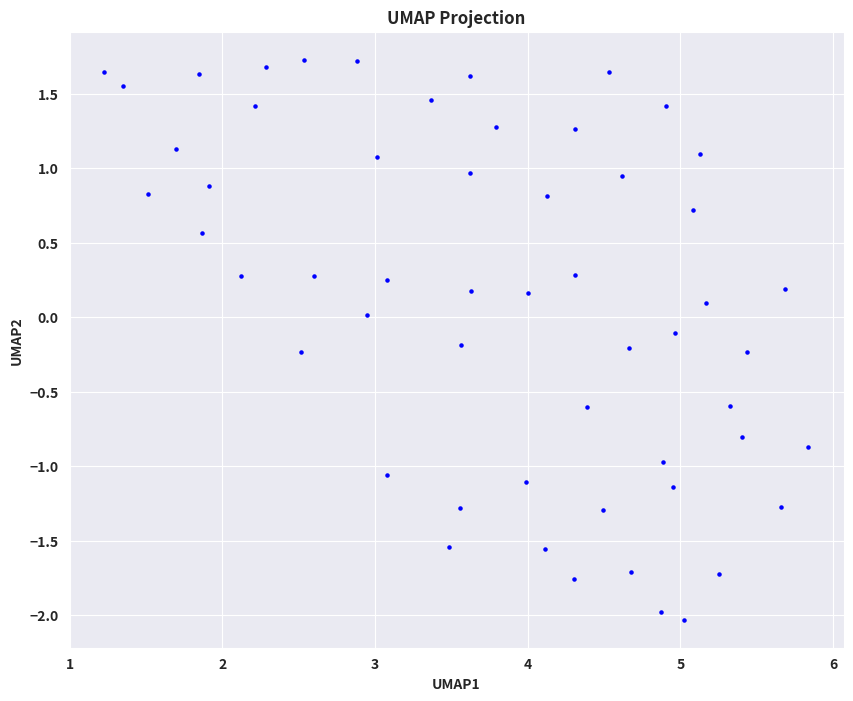

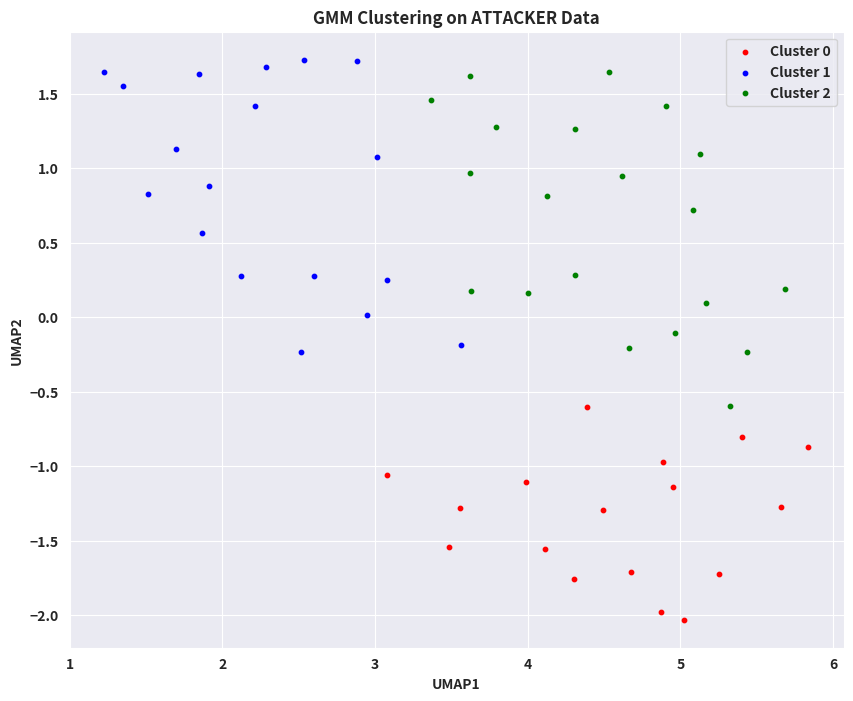

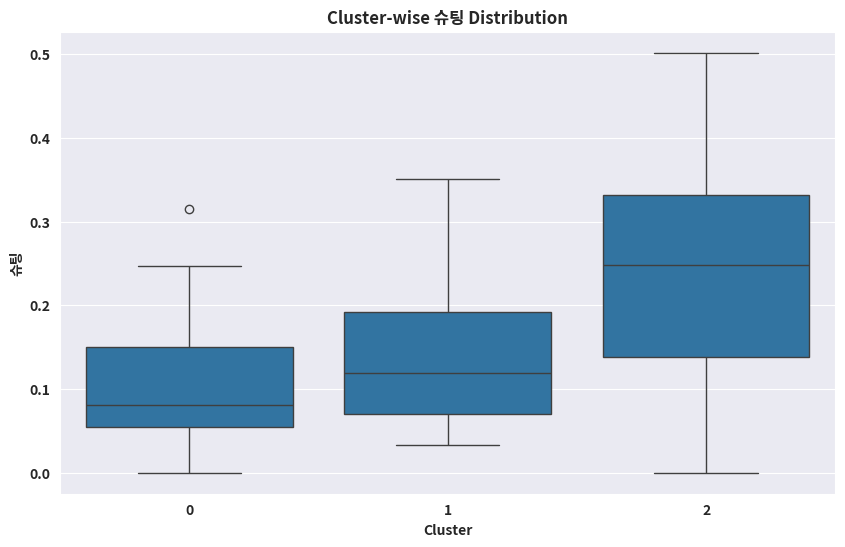

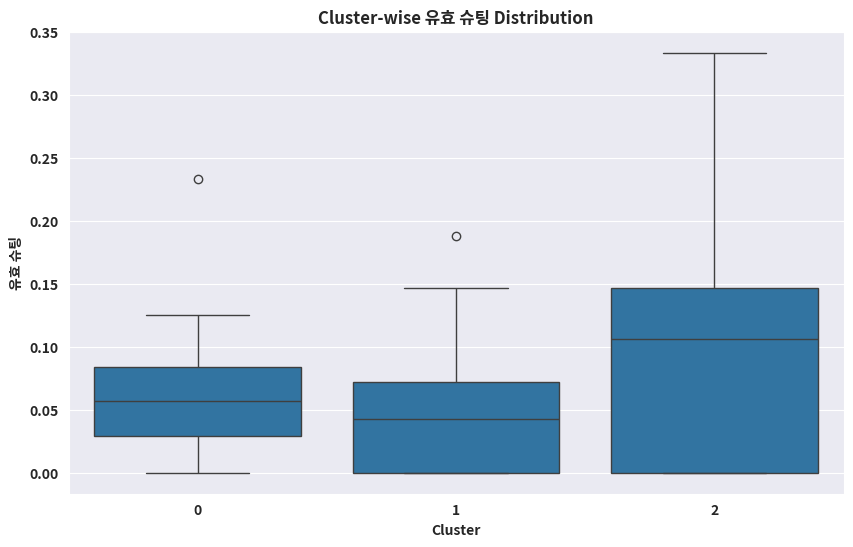

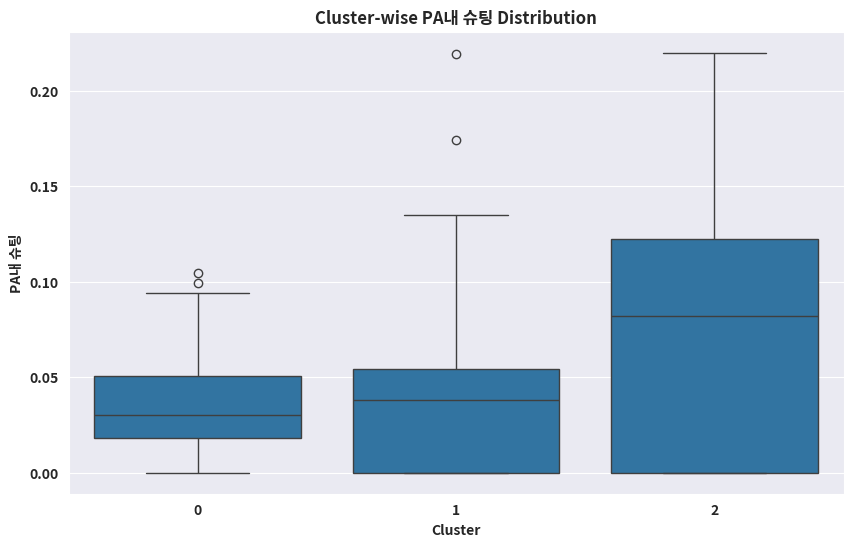

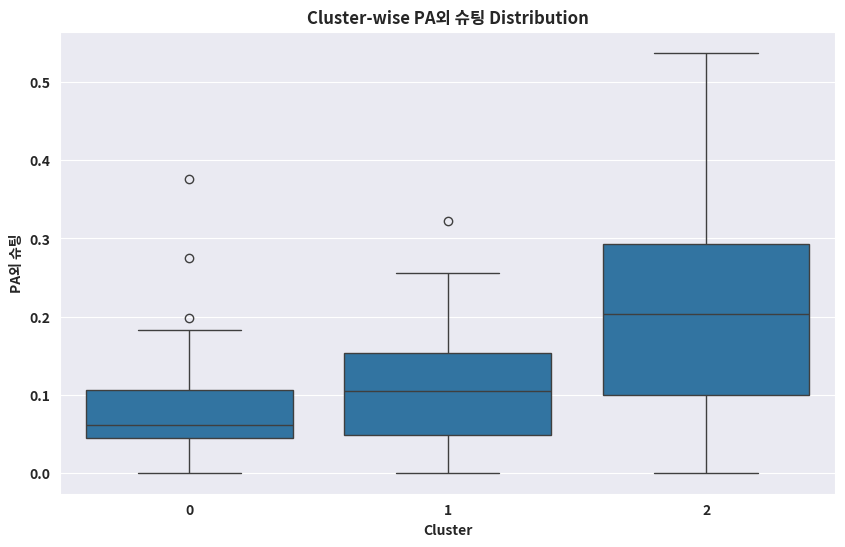

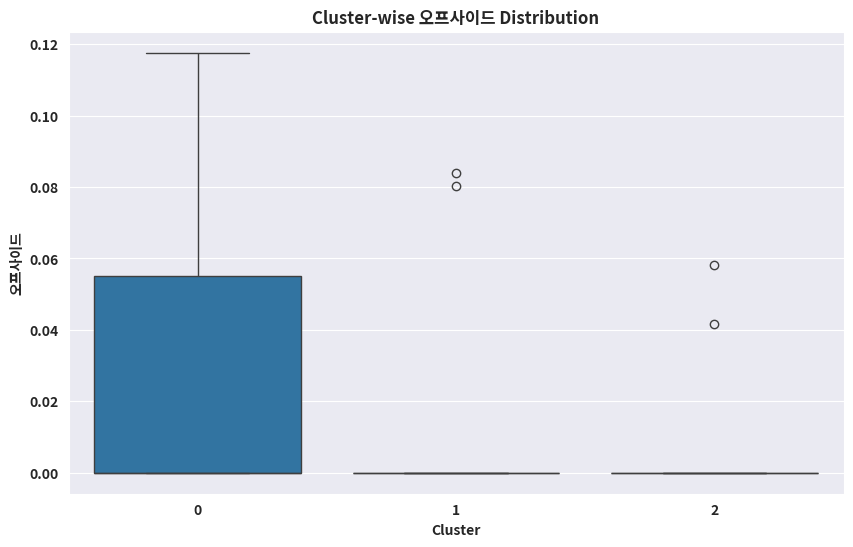

ValueError: Could not interpret value `드리블 시도` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [54]:
# 분류된 포지션 별로 차원축소 및 군집분석 실시

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
data_atk_selected = data_selected[data_selected['Cluster'] == 4]
embedding_atk = reducer.fit_transform(data_atk_selected.iloc[:, :-1])
embedding_atk_df = pd.DataFrame(embedding_atk, columns=['UMAP1', 'UMAP2'])

# 차원 축소 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embedding_atk[:, 0], embedding_atk[:, 1], s=5, c='blue')
plt.title('UMAP Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')


plt.show()

# GaussianMixture 모델 학습
gmm_atk = GaussianMixture(n_components=3, random_state=82)
gmm_atk.fit(embedding_atk_df)

# 클러스터 레이블 예측
atk_cluster_labels = gmm_atk.predict(embedding_atk_df)

# 예측된 클러스터 레이블을 데이터프레임에 추가
embedding_atk_df = embedding_atk_df.copy()
embedding_atk_df['Cluster'] = atk_cluster_labels
data_atk_selected = data_atk_selected.copy()
data_atk_selected['Cluster'] = atk_cluster_labels


# 시각화
colors = ['red', 'blue', 'green', 'cyan', 'black', 'magenta', 'orange']

plt.figure(figsize=(10, 8))
for i in range(3):
    cluster_data = embedding_atk_df[embedding_atk_df['Cluster'] == i]
    plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
                color=colors[i], label=f'Cluster {i}', s=10)

plt.title('GMM Clustering on ATTACKER Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=data_atk_selected)
    plt.title(f'Cluster-wise {feature} Distribution')
    plt.show()

In [ ]:
atk_positions = ["FINISHER", "PRESSING FORWARD", "WIDE ATTACKER"]
data_atk_selected['Position'] = data_atk_selected['Cluster'].apply(lambda x: atk_positions[x])
df.loc[data_atk_selected.index, 'Second Position'] = data_atk_selected['Position']

In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
data_def_selected = data_selected[data_selected['Cluster'] == 0]
embedding_def = reducer.fit_transform(data_def_selected.iloc[:, :-1])
embedding_def_df = pd.DataFrame(embedding_def, columns=['UMAP1', 'UMAP2'])

# 차원 축소 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embedding_def[:, 0], embedding_def[:, 1], s=5, c='blue')
plt.title('UMAP Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# GaussianMixture 모델 학습
gmm_def = GaussianMixture(n_components=3, random_state=82)
gmm_def.fit(embedding_def_df)

# 클러스터 레이블 예측
def_cluster_labels = gmm_def.predict(embedding_def_df)

# 예측된 클러스터 레이블을 데이터프레임에 추가
# 예측된 클러스터 레이블을 데이터프레임에 추가
embedding_def_df = embedding_def_df.copy()
embedding_def_df['Cluster'] = def_cluster_labels
data_def_selected = data_def_selected.copy()
data_def_selected['Cluster'] = def_cluster_labels


# 시각화
colors = ['red', 'blue', 'green', 'cyan', 'black', 'magenta', 'orange']

plt.figure(figsize=(10, 8))
for i in range(3):
    cluster_data = embedding_def_df[embedding_def_df['Cluster'] == i]
    plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
                color=colors[i], label=f'Cluster {i}', s=10)

plt.title('GMM Clustering on DEFENDER Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=data_def_selected)
    plt.title(f'Cluster-wise {feature} Distribution')
    plt.show()

In [ ]:
def_positions = ["WIDE CENTER BACK", "BALL PLAYING DEFENDER", "CENTER BACK"]
data_def_selected['Position'] = data_def_selected['Cluster'].apply(lambda x: def_positions[x])
df.loc[data_def_selected.index, 'Second Position'] = data_def_selected['Position']

In [ ]:
# UMAP 차원 축소
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
data_cm_selected = data_selected[data_selected['Cluster'] == 2]
embedding_cm = reducer.fit_transform(data_cm_selected.iloc[:, :-1])
embedding_cm_df = pd.DataFrame(embedding_cm, columns=['UMAP1', 'UMAP2'])

# GaussianMixture 모델 학습
gmm_cm = GaussianMixture(n_components=3, random_state=82)
gmm_cm.fit(embedding_cm_df)

# 클러스터 레이블 예측
cm_cluster_labels = gmm_cm.predict(embedding_cm_df)

# 예측된 클러스터 레이블을 데이터프레임에 추가
embedding_cm_df = embedding_cm_df.copy()
embedding_cm_df['Cluster'] = cm_cluster_labels
data_cm_selected = data_cm_selected.copy()
data_cm_selected['Cluster'] = cm_cluster_labels

# 새로운 포지션 값을 할당
cm_positions = ["BOX TO BOX", "DISTRIBUTOR", "DEEP LYING PLAYMAKER"]
data_cm_selected['Position'] = data_cm_selected['Cluster'].apply(lambda x: cm_positions[x])

# 원래 df에 Second Position 값을 업데이트
for idx in data_cm_selected.index:
    df.loc[idx, 'Second Position'] = data_cm_selected.loc[idx, 'Position']

plt.figure(figsize=(10, 8))
for i in range(3):
    cluster_data = embedding_cm_df[embedding_cm_df['Cluster'] == i]
    plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
                color=colors[i], label=f'Cluster {i}', s=10)

plt.title('GMM Clustering on AM Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=data_cm_selected)
    plt.title(f'Cluster-wise {feature} Distribution')
    plt.show()


In [ ]:
cm_positions = ["PLAYMAKER", "DISTRIBUTOR", "BOX TO BOX"]
data_cm_selected['Position'] = data_cm_selected['Cluster'].apply(lambda x: cm_positions[x])
df.loc[data_cm_selected.index, 'Second Position'] = data_cm_selected['Position']

In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
data_am_selected = data_selected[data_selected['Cluster'] == 1]
embedding_am = reducer.fit_transform(data_am_selected.iloc[:, :-1])
embedding_am_df = pd.DataFrame(embedding_am, columns=['UMAP1', 'UMAP2'])

# 차원 축소 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embedding_am[:, 0], embedding_am[:, 1], s=5, c='blue')
plt.title('UMAP Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# GaussianMixture 모델 학습
gmm_am = GaussianMixture(n_components=3, random_state=82)
gmm_am.fit(embedding_am_df)

# 클러스터 레이블 예측
am_cluster_labels = gmm_am.predict(embedding_am_df)

# 예측된 클러스터 레이블을 데이터프레임에 추가
embedding_am_df = embedding_am_df.copy()
embedding_am_df['Cluster'] = am_cluster_labels
data_am_selected = data_am_selected.copy()
data_am_selected['Cluster'] = am_cluster_labels

# 시각화
colors = ['red', 'blue', 'green', 'cyan', 'black', 'magenta', 'orange']

plt.figure(figsize=(10, 8))
for i in range(3):
    cluster_data = embedding_am_df[embedding_am_df['Cluster'] == i]
    plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
                color=colors[i], label=f'Cluster {i}', s=10)

plt.title('GMM Clustering on AM Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=data_am_selected)
    plt.title(f'Cluster-wise {feature} Distribution')
    plt.show()


In [ ]:
am_positions = ["BOX CRASHER", "ORCHESTRATOR", "CREATOR"]
data_am_selected['Position'] = data_am_selected['Cluster'].apply(lambda x: am_positions[x])
df.loc[data_am_selected.index, 'Second Position'] = data_am_selected['Position']

In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
data_dm_selected = data_selected[data_selected['Cluster'] == 3]
embedding_dm = reducer.fit_transform(data_dm_selected.iloc[:, :-1])
embedding_dm_df = pd.DataFrame(embedding_dm, columns=['UMAP1', 'UMAP2'])

# 차원 축소 결과 시각화
plt.figure(figsize=(10, 8))
plt.scatter(embedding_dm[:, 0], embedding_dm[:, 1], s=5, c='blue')
plt.title('UMAP Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# GaussianMixture 모델 학습
gmm_dm = GaussianMixture(n_components=3, random_state=82)
gmm_dm.fit(embedding_dm_df)

# 클러스터 레이블 예측
dm_cluster_labels = gmm_dm.predict(embedding_dm_df)

# 예측된 클러스터 레이블을 데이터프레임에 추가
embedding_dm_df = embedding_dm_df.copy()
embedding_dm_df['Cluster'] = dm_cluster_labels
data_dm_selected = data_dm_selected.copy()
data_dm_selected['Cluster'] = dm_cluster_labels

# 시각화
colors = ['red', 'blue', 'green', 'cyan', 'black', 'magenta', 'orange']

plt.figure(figsize=(10, 8))
for i in range(3):
    cluster_data = embedding_dm_df[embedding_dm_df['Cluster'] == i]
    plt.scatter(cluster_data['UMAP1'], cluster_data['UMAP2'], 
                color=colors[i], label=f'Cluster {i}', s=10)

plt.title('GMM Clustering on DM Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=data_dm_selected)
    plt.title(f'Cluster-wise {feature} Distribution')
    plt.show()


In [ ]:
dm_positions = ["HALF BACK", "OVERLAP", "BALL WINING MID"]
data_dm_selected['Position'] = data_dm_selected['Cluster'].apply(lambda x: dm_positions[x])
df.loc[data_dm_selected.index, 'Second Position'] = data_dm_selected['Position']

In [ ]:
print(df.head())

In [ ]:
result_positions = def_positions + dm_positions + cm_positions + am_positions + atk_positions
print(result_positions)

wide_attacker = df[df['Second Position'] == 'PRESSING FORWARD']
for player in wide_attacker['선수명'].to_list():
    print(player)

In [ ]:
import numpy as np

columns = [
    "슈팅", "유효 슈팅", "PA내 슈팅", "PA외 슈팅",
    "오프사이드",
    "드리블 시도", "키패스", "전방 패스 시도", "후방 패스 시도",
    "횡패스 시도",
    "공격지역패스 시도", "수비지역패스 시도",
    "중앙지역패스 시도", "롱패스 시도", "중거리패스 시도",
    "숏패스 시도", "크로스 시도"
    ,"경합 공중 시도", "태클 시도",
    "클리어링", "인터셉트", "차단", "획득", "블락", "볼미스", "파울", "피파울"
]
# 각 포지션의 데이터 필터링
orchestrator_data = df[df['Second Position'] == 'ORCHESTRATOR'][columns]
creator_data = df[df['Second Position'] == 'CREATOR'][columns]
box_crasher_data = df[df['Second Position'] == 'BOX CRASHER'][columns]

# 각 포지션의 평균 값 계산
orchestrator_mean = orchestrator_data.mean()
creator_mean = creator_data.mean()
box_crasher_mean = box_crasher_data.mean()

# 레이다 차트에 사용할 컬럼들 선택
num_vars = len(columns)

# 레이다 차트를 위한 각도 계산
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 각도를 다시 추가하여 닫힌 형태로 만듦

# 포지션별 평균 값에 대해 레이다 차트를 그리기 위한 데이터 준비
orchestrator_values = orchestrator_mean.values.flatten().tolist()
orchestrator_values += orchestrator_values[:1]
creator_values = creator_mean.values.flatten().tolist()
creator_values += creator_values[:1]
box_crasher_values = box_crasher_mean.values.flatten().tolist()
box_crasher_values += box_crasher_values[:1]

# 레이다 차트 생성
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# 각 포지션에 대해 레이다 차트 그리기
ax.plot(angles, orchestrator_values, linewidth=1, linestyle='solid', label='Orchestrator')
ax.fill(angles, orchestrator_values, alpha=0.25)

ax.plot(angles, creator_values, linewidth=1, linestyle='solid', label='Creator')
ax.fill(angles, creator_values, alpha=0.25)

ax.plot(angles, box_crasher_values, linewidth=1, linestyle='solid', label='Box Crasher')
ax.fill(angles, box_crasher_values, alpha=0.25)

# 컬럼 이름을 각도에 맞게 설정
ax.set_xticks(angles[:-1])
ax.set_xticklabels(columns)

# 범례 및 제목 설정
plt.title('Comparison of Advanced Midfielder Types')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


In [ ]:
hjw = df[df["선수명"] == '황재원']
kjs = df[df['선수명'] == '김진수']
hmk = df[df["선수명"] == '황문기']
kjh = df[df["선수명"] == '김진호']
psw = df[df["선수명"] == '박승욱']
syw = df[df['선수명'] == '설영우']

hjw_sp = hjw['Second Position'].tolist()
kjs_sp = kjs['Second Position'].tolist()
hmk_sp = hmk['Second Position'].tolist()
kjh_sp = kjh['Second Position'].tolist()
psw_sp = psw['Second Position'].tolist()
syw_sp = syw['Second Position'].tolist()

print(hjw_sp)
hjw = hjw[columns]
kjs = kjs[columns]
hmk = hmk[columns]
kjh = kjh[columns]
psw = psw[columns]
syw = syw[columns]

# 각 포지션의 평균 값 계산
hjw_mean = hjw.mean()
kjs_mean = kjs.mean()
hmk_mean = hmk.mean()
kjh_mean = kjh.mean()
psw_mean = psw.mean()
syw_mean = syw.mean()

# 레이다 차트에 사용할 컬럼들 선택
num_vars = len(columns)

# 레이다 차트를 위한 각도 계산
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 각도를 다시 추가하여 닫힌 형태로 만듦

# 포지션별 평균 값에 대해 레이다 차트를 그리기 위한 데이터 준비
hjw_values = hjw_mean.values.flatten().tolist()
hjw_values += hjw_values[:1]
kjs_values = kjs_mean.values.flatten().tolist()
kjs_values += kjs_values[:1]
hmk_values = hmk_mean.values.flatten().tolist()
hmk_values += hmk_values[:1]
kjh_values = kjh_mean.values.flatten().tolist()
kjh_values += kjh_values[:1]
psw_values = psw_mean.values.flatten().tolist()
psw_values += psw_values[:1]
syw_values = syw_mean.values.flatten().tolist()
syw_values += syw_values[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# 각 선수에 대해 레이더 차트 그리기
ax.plot(angles, hjw_values, linewidth=1, linestyle='solid', label=f'황재원: {hjw_sp[0]} ', color='skyblue')
ax.fill(angles, hjw_values, alpha=0.25)

ax.plot(angles, kjs_values, linewidth=1, linestyle='solid', label=f'김진수: {kjs_sp[0]}', color='green')
ax.fill(angles, kjs_values, alpha=0.25)

ax.plot(angles, hmk_values, linewidth=1, linestyle='solid', label=f'황문기: {hmk_sp[0]}', color='orange')
ax.fill(angles, hmk_values, alpha=0.25)

ax.plot(angles, kjh_values, linewidth=1, linestyle='solid', label=f'김진호: {kjh_sp[0]}', color='yellow')
ax.fill(angles, kjh_values, alpha=0.25)

ax.plot(angles, psw_values, linewidth=1, linestyle='solid', label=f'박승욱: {psw_sp[0]}', color='black')
ax.fill(angles, psw_values, alpha=0.25)

ax.plot(angles, syw_values, linewidth=1, linestyle='solid', label=f'설영우: {syw_sp[0]}', color='blue')
ax.fill(angles, syw_values, alpha=0.25)

# 컬럼 이름을 각도에 맞게 설정
ax.set_xticks(angles[:-1])
ax.set_xticklabels(columns)

# 범례 및 제목 설정
plt.title('Comparison of National Team Fullback Types')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

In [ ]:
columns = ['득점', '도움', '슈팅', '유효 슈팅', 'PA내 슈팅', 'PA외 슈팅', '오프사이드', '드리블 성공', '패스 성공', '키패스', '전방 패스 성공', '공격지역패스 성공', '중앙지역패스 성공', '롱패스 성공', '중거리패스 성공', '크로스 성공', '경합 지상 성공', '경합 공중 성공', '태클 성공', '차단', '볼미스', '피파울']

# 선수 데이터
lsw = df[df['선수명'] == '이승우']
smk = df[df['선수명'] == '송민규']
ews = df[df['선수명'] == '엄원상']
jmk = df[df['선수명'] == '주민규']

# 포지션 정보 저장
lsw_sp = lsw['Second Position'].tolist()
smk_sp = smk['Second Position'].tolist()
ews_sp = ews['Second Position'].tolist()
jmk_sp = jmk['Second Position'].tolist()

# 각 선수 데이터에서 필요한 컬럼만 선택
lsw = lsw[columns]
smk = smk[columns]
ews = ews[columns]
jmk = jmk[columns]

# 각 포지션의 평균 값 계산
lsw_mean = lsw.mean()
smk_mean = smk.mean()
ews_mean = ews.mean()
jmk_mean = jmk.mean()

# 레이다 차트를 위한 각도 계산
num_vars = len(columns)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 각도를 다시 추가하여 닫힌 형태로 만듦

# 포지션별 평균 값에 대해 레이다 차트를 그리기 위한 데이터 준비
lsw_values = lsw_mean.values.flatten().tolist()
lsw_values += lsw_values[:1]
smk_values = smk_mean.values.flatten().tolist()
smk_values += smk_values[:1]
ews_values = ews_mean.values.flatten().tolist()
ews_values += ews_values[:1]
jmk_values = jmk_mean.values.flatten().tolist()
jmk_values += jmk_values[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# 각 선수에 대해 레이더 차트 그리기
ax.plot(angles, lsw_values, linewidth=1, linestyle='solid', label=f'이승우: {lsw_sp[0]}', color='skyblue')

ax.plot(angles, smk_values, linewidth=1, linestyle='solid', label=f'송민규: {smk_sp[0]}', color='green')

ax.plot(angles, ews_values, linewidth=1, linestyle='solid', label=f'엄원상: {ews_sp[0]}', color='orange')

ax.plot(angles, jmk_values, linewidth=1, linestyle='solid', label=f'주민규: {jmk_sp[0]}', color='purple')

# 컬럼 이름을 각도에 맞게 설정
ax.set_xticks(angles[:-1])
ax.set_xticklabels(columns)

# 범례 및 제목 설정
plt.title('Comparison of Selected Player Types')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


In [ ]:
columns = [
    "슈팅", "유효 슈팅", "PA내 슈팅", "PA외 슈팅",
    "오프사이드",
    "드리블 시도", "키패스", "전방 패스 시도", "후방 패스 시도",
    "횡패스 시도",
    "공격지역패스 시도", "수비지역패스 시도",
    "중앙지역패스 시도", "롱패스 시도", "중거리패스 시도",
    "숏패스 시도", "크로스 시도"
    ,"경합 공중 시도", "태클 시도",
    "클리어링", "인터셉트", "차단", "획득", "블락", "볼미스", "파울", "피파울"
]

jmk = df[df['선수명'] == '주민규']
yago = df[df['선수명'] == '야고']

jmk_sp = jmk['Second Position'].tolist()
yago_sp = yago['Second Position'].tolist()

jmk = jmk[columns]
yago = yago[columns]

jmk_mean = jmk.mean()
yago_mean = yago.mean()

# 레이다 차트를 위한 각도 계산
num_vars = len(columns)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 각도를 다시 추가하여 닫힌 형태로 만듦

jmk_values = jmk_mean.values.flatten().tolist()
jmk_values += jmk_values[:1]
yago_values = yago_mean.values.flatten().tolist()
yago_values += yago_values[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

ax.plot(angles, jmk_values, linewidth=1, linestyle='solid', label=f'주민규: {jmk_sp[0]}', color='purple')
ax.fill(angles, jmk_values, alpha=0.25)

ax.plot(angles, yago_values, linewidth=1, linestyle='solid', label=f'야고: {yago_sp[0]}', color='orange')
ax.fill(angles, yago_values, alpha=0.25)

# 컬럼 이름을 각도에 맞게 설정
ax.set_xticks(angles[:-1])
ax.set_xticklabels(columns)

# 범례 및 제목 설정
plt.title('Comparison of Selected Player Types')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


In [ ]:
cm = df[df['Position'] == 'CENTRAL MIDFIELDER']
print(cm)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 컬럼 선택
columns = [
    "슈팅", "유효 슈팅", "PA내 슈팅", "PA외 슈팅",
    "오프사이드",
    "드리블 시도", "키패스", "전방 패스 시도", "후방 패스 시도",
    "횡패스 시도",
    "공격지역패스 시도", "수비지역패스 시도",
    "중앙지역패스 시도", "롱패스 시도", "중거리패스 시도",
    "숏패스 시도", "크로스 시도",
    "경합 공중 시도", "태클 시도",
    "클리어링", "인터셉트", "차단", "획득", "블락", "볼미스", "파울", "피파울"
]

# 포지션별 선수 데이터 추출
positions = ["DEEP MIDFIELDER", "CENTRAL MIDFIELDER", "ADVANCED MIDFIELDER"]
position_means = {}

for position in positions:
    target = df[df["Position"] == position]
    position_means[position] = target[columns].mean()

# 레이다 차트를 위한 각도 계산
num_vars = len(columns)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 각도를 다시 추가하여 닫힌 형태로 만듦

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# 각 포지션에 대해 레이더 차트 그리기
colors = ['blue', 'green', 'red', 'purple', 'orange']
for idx, (position, means) in enumerate(position_means.items()):
    values = means.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=position, color=colors[idx])
    ax.fill(angles, values, alpha=0.2)

# 컬럼 이름을 각도에 맞게 설정
ax.set_xticks(angles[:-1])
ax.set_xticklabels(columns)

# 범례 및 제목 설정
plt.title('Comparison of Positions in K-League')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


In [ ]:
# 'Second Position'이 'OVERLAP'인 선수들의 이름 출력
selected = df[df['Second Position'] == 'OVERLAP']
selected_players = selected['선수명'].tolist()

# 선수 이름 출력
for player in selected_players:
    print(player)


In [ ]:
# 'Second Position'이 'OVERLAP'인 선수들의 이름 출력
selected = df[df['Second Position'] == 'WIDE CENTER BACK']
selected_players = selected['선수명'].tolist()

print(selected_players)


In [ ]:
print(df)